In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.parameter import Parameter
from torch.autograd import Variable
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Pre-processing of dataset
df=pd.read_csv('digit-recognizer/train.csv')
df=df.sample(frac=1)
val_data = df[:4200]      # 10% of dataset
train_data = df[4200:]    # 90% of dataset
train_target = torch.tensor(train_data['label'].values.astype(np.float32))
train = torch.tensor(train_data.drop('label', axis = 1).values.astype(np.float32)) 
val_target = torch.tensor(val_data['label'].values.astype(np.float32))
val = torch.tensor(val_data.drop('label', axis = 1).values.astype(np.float32)) 
train=train.view(-1,1,28,28)/255
val=val.view(-1,1,28,28)/255
train_tensor = torch.utils.data.TensorDataset(train, train_target) 
train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = 1024, shuffle = True)
val_tensor = torch.utils.data.TensorDataset(val, val_target) 
val_loader = torch.utils.data.DataLoader(dataset = val_tensor, batch_size = 1024, shuffle = True)

data_loaders = {"train": train_loader, "val": val_loader}

In [3]:
class linear(nn.Module):
    """ 
        Linear activation function
        
        Range: (-∞,∞)
    """
    def __init__(self,input_features,slope=None):
        """
        Parameters:
                    input_features - input features
                    slope - trainable parameter
        """
        super(linear,self).__init__()
        self.input_features=input_features
        if slope==None:
            self.slope=Parameter(torch.tensor(1.0))
        else:
            self.slope=Parameter(torch.tensor(slope))        
        self.slope.requiresGrad = True 
        
    def forward(self, x):
        """
        Parameters: 
            x: Input tensor

        Returns: 
            y: Output tensor given by f(x)= slope.x
        """
        y = x*self.slope
        return y

Linear activation function with slope 1.00


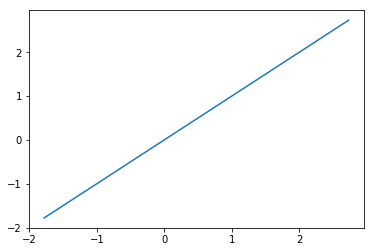

In [4]:
print("Linear activation function with slope 1.00")
x=torch.sort(torch.randn(100)).values
activation=linear(100)
y=activation(x)
plt.plot(x.numpy(),y.detach().numpy())

In [5]:
class sigmoid(nn.Module):
    """ 
            Sigmoid activation function

            Range: (0,1)
            
            Drawbacks:
            1. Sigmoids saturate and kill gradients
            2. Sigmoid outputs are not zero-centered.
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        """
        Parameters: 
                x: Input tensor

        Returns: 
                y: Output tensor given by f(x) = 1/(1+exp(-x))
        """
        y=1/(1+torch.exp((-1)*x))
        return y

Sigmoid activation function


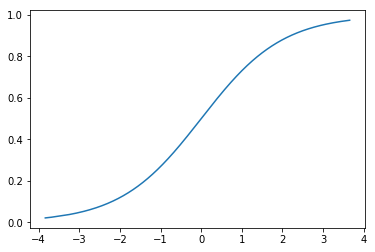

In [6]:
print("Sigmoid activation function")
x=torch.sort(torch.randn(10000)).values
activation=sigmoid()
y=activation(x)
plt.plot(x.numpy(),y.numpy())

In [7]:
class relu(nn.Module):
    """ 
            ReLU activation function

            Range: (0,∞)
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        """
        Parameters: 
                x: Input tensor

        Returns: 
                y: Output tensor given by f(x) = max(0,x)
        """
        y=torch.clamp(x,0)
        return y

ReLU activation function


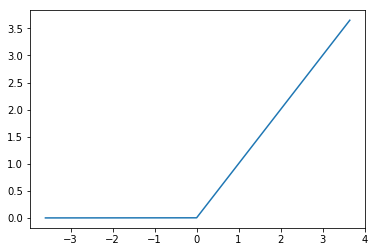

In [8]:
print("ReLU activation function")
x=torch.sort(torch.randn(10000)).values
activation=relu()
y=activation(x)
plt.plot(x.numpy(),y.numpy())

In [9]:
class leaky_relu(nn.Module):
    """ 
           Leaky ReLU activation function

           Range: (-∞,∞)
            
           Advantage:
                Prevents the problem of dying neurons in ReLU due to fragile gradients
    """
    def __init__(self,alpha=0.01):
        """
        Parameters:
            input_features - input features
            alpha - constant parameter
          
        Returns: 
            y: Output tensor given by f(x)= slope.x
        """
        super().__init__()
        self.alpha=alpha
        
    def forward(self, x):
        """
        Parameters: 
                x: Input tensor

        Returns: 
                y: Output tensor
        """
        positive_indices=torch.where(x>=0)
        negative_indices=torch.where(x<0)
        y[positive_indices]=x[positive_indices]
        y[negative_indices]=x[negative_indices]*self.alpha
        return y

Leaky ReLU activation function with alpha(negative-slope) 0.03


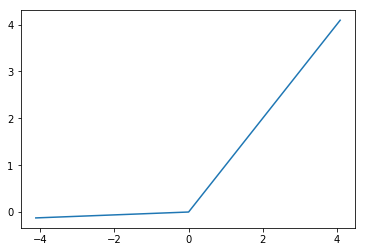

In [10]:
print("Leaky ReLU activation function with alpha(negative-slope) 0.03")
x=torch.sort(torch.randn(10000)).values
activation=leaky_relu(alpha=0.03)
y=activation(x)
plt.plot(x.numpy(),y.numpy())

In [11]:
class soft_plus(nn.Module):
    """ 
            SoftPlus activation function
         
            Range: (0,∞)
            
            Interesting note: Derivative is equal to sigmoid function
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        """
        Parameters: 
                x: Input tensor

        Returns: 
                y: Output tensor given by ln (1+exp(x))
        """
        y=torch.log(1+torch.exp(x))
        return y

SoftPlus activation function


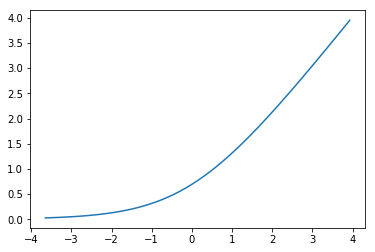

In [12]:
print("SoftPlus activation function")
x=torch.sort(torch.randn(10000)).values
activation=soft_plus()
y=activation(x)
plt.plot(x.numpy(),y.numpy())

In [13]:
class tanh(nn.Module):
    """ 
            Tanh activation function
         
            Range: (-1,1)
            
            Interesting note: It can be scaled to sigmoid as tanh(x)=2sigmoid(2x)-1
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        """
        Parameters: 
                x: Input tensor

        Returns: 
                y: Output
        """
        sigma=sigmoid()
        y=2*sigma(2*x) - 1
        return y

Tanh activation function


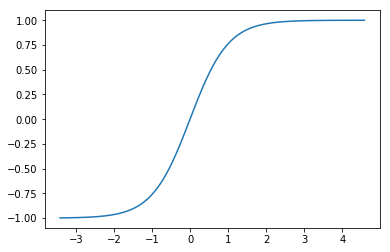

In [14]:
print("Tanh activation function")
x=torch.sort(torch.randn(10000)).values
activation=tanh()
y=activation(x)
plt.plot(x.numpy(),y.numpy())

In [15]:
class swish(nn.Module):
    """ 
            Swish activation function
         
            Range: (≈-0.278,∞)
                
            Interesting note: It is bounded below and unbounded above, so similar to ReLU
      """
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        """
            Parameters: 
                x: Input tensor

            Returns: 
                y: Output tensor given by f(x)= x * sigmoid(x)
        """
        sigma=sigmoid()
        y=x*sigma(x)
        return y

Swish activation function


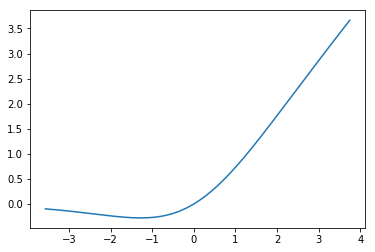

In [16]:
print("Swish activation function")
x=torch.sort(torch.randn(10000)).values
activation=swish()
y=activation(x)
plt.plot(x.numpy(),y.numpy())

In [17]:
class mish(nn.Module):
    """ 
            Mish activation function
         
            Range: (≈-0.31,∞)
                
            Interesting note: It is bounded below and unbounded above, so similar to ReLU
      """
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        """
            Parameters: 
                x: Input tensor

            Returns: 
                y: Output tensor given by f(x)= x * tanh(soft-plus(x))
        """
        Tanh=tanh()
        SoftPlus=soft_plus()
        y=x*Tanh(SoftPlus(x))
        return y

Mish activation function


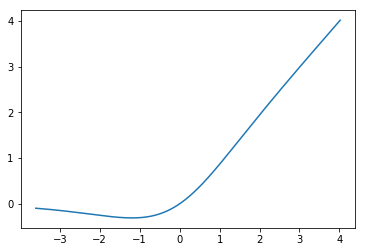

In [18]:
print("Mish activation function")
x=torch.sort(torch.randn(10000)).values
activation=mish()
y=activation(x)
plt.plot(x.numpy(),y.numpy())

In [19]:
def train_model(model,data_loaders ):
    '''
    Function trains the model and prints out the training log.
    INPUT:
        model - initialized PyTorch model ready for training
        train_loader - PyTorch dataloader for training data
        val_loader - PyTorch dataloader for evaluation on cross-validation data
    '''
    
    loss_fn = nn.NLLLoss()
    learning_rate = 1e-6
    num_epochs = 5
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for e in range(num_epochs):
        print('Epoch {}/{}'.format(e, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
            
            running_loss = 0
            for images, labels in data_loaders[phase]:
                labels = labels.to(device='cpu', dtype=torch.int64)
                log_probs = model(images)
                loss = loss_fn(log_probs, labels)
                if phase=='train':    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
                if phase=='train':
                    print("Training loss: "+str(running_loss))
                else:
                    print("Validation loss: "+str(running_loss))

In [20]:
class CNNClassifier(nn.Module):
    '''
    A classifier based on CNN architecture
    '''
    def __init__(self,activation):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            activation,
            nn.MaxPool2d(2))
 
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            activation,
            nn.MaxPool2d(2))
    
        self.fc = nn.Linear(7*7*32, 10)
 
    def forward(self, x):
        
        out = self.block1(x)

        out = self.block2(out)
        
        # Flatten the output of block2
        out = out.view(out.size(0), -1)
        
        out = self.fc(out)
        
        return out

In [21]:
activation_function = relu()
model = CNNClassifier(activation_function)
train_model(model,data_loaders)

Epoch 0/4
----------
Training loss: -0.009459600783884525
Training loss: -0.020990476943552494
Training loss: -0.032949487678706646
Training loss: -0.045388415455818176
Training loss: -0.05713306460529566
Training loss: -0.06927186902612448
Training loss: -0.07978237979114056
Training loss: -0.09248555079102516
Training loss: -0.10723007936030626
Training loss: -0.12096972204744816
Training loss: -0.1339677246287465
Training loss: -0.1486990638077259
Training loss: -0.16218342073261738
Training loss: -0.17742332071065903
Training loss: -0.18944960180670023
Training loss: -0.20091585256159306
Training loss: -0.21422024350613356
Training loss: -0.2260683411732316
Training loss: -0.24136090837419033
Training loss: -0.25617635529488325
Training loss: -0.27123642433434725
Training loss: -0.28514855168759823
Training loss: -0.30033588595688343
Training loss: -0.3153181541711092
Training loss: -0.33038349356502295
Training loss: -0.3447676347568631
Training loss: -0.3601933438330889
Training 

In [22]:
# Pre-processing of dataset
df=pd.read_csv('digit-recognizer/test.csv')
test_data = torch.tensor(df).values.astype(np.float32) 
test_data=test_data.view(-1,1,28,28)/255
test_tensor = torch.utils.data.TensorDataset(train, train_target) 
test_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = 1024, shuffle = False)


ValueError: could not determine the shape of object type 'DataFrame'